<a href="https://colab.research.google.com/github/blaze010/CS6700-Reinforcement_Learning/blob/main/Assignment%201/Programming_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center >CS6700: Reinforcement Learning
## <center >Programming Assignment 1
## <center> TD Learning: SARSA and Q-Learning
###  Submitted by: 
### Gautham Govind A: EE19B022
### Vishnu Vinod: CS19B048 

## Importing necessary packages

In [1]:
import sys
import scipy
import numpy as np
import seaborn as sns
from tqdm import tqdm
from math import floor
import matplotlib.pyplot as plt

## Utility functions

We require functions capable of converting from row-column based indexing and sequential indexing of grid cells. These are defined below: 

In [2]:
# Converts row_column format to sequential (state number) format
# Input  - 2D array of grid cells in (row, col) format
# Output - 1D array of corresponding state numbers
def row_col_to_seq(row_col, num_cols): 
    return row_col[:,0] * num_cols + row_col[:,1]

# Converts sequential (state number) format to row_column format 
# Input  - 1D array of grid cells in state number format
# Output - 2D array of grid cells in corresponding (row, col) format 
def seq_to_col_row(seq, num_cols): 
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

In [3]:
row_col_to_seq(np.array([[1,0]]), 2)

array([2])

## Defining the environment

The environment class, the definition of which has already been provided as part of the problem statement, is defined here:

In [4]:
class GridWorld:

    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters:
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind
    
        # added to help naming conventions
        self.wind_mode = None
        self.start_mode = None
        self.stochasticity = None
        
        # 'windy' if wind=True | 'clear' if wind=False
        self.wind_mode = '_windy' if wind else '_clear'
        
        # 's1' if starting from [0,4] | 's2' if starting from [3,6] | None otherwise
        if (start_state == np.array([[0,4]])).all(): self.start_mode = '_s1'
        elif (start_state == np.array([[3,6]])).all(): self.start_mode = '_s2'
        

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias
        
        # 'detrm' if deterministic (p=1) | 'noisy' if stochastic (p!=1)
        self.stochasticity = '_detrm' if (p_good_transition == 1.) else '_noisy'

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal
        
        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):
                        
                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
        return int(self.start_state_seq)
      
    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):
            
            p += self.P[state, next_state, action]
            
            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):
            arr = self.P[next_state, :, 3]
            next_next = np.where(arr == np.amax(arr))
            next_next = next_next[0][0]
            return next_next, self.R[next_next]
        else:
            return next_state, self.R[next_state]

## Action Policy Definitions

This part defines the necessary action selection policies like $\epsilon$-greedy and softmax. They are used to select the next action of the RL agent based on the state and the Q-values of each action.


First, we create an abstract BasePolicy() class:

In [5]:
class BasePolicy:
    @property
    def name(self):
        return 'base_policy'

    def select_action(self, state_id):
        raise NotImplemented

## $\epsilon$ - Greedy Policy
We first create an epsilon greedy policy which makes use of action value functions as the quantity based on which actions are chosen:

\begin{equation}
next\_action = 
\begin{cases} 
      \text{argmax}_a(Q(a)) & \text{with probability }1-\epsilon \\
      \text{random}(a[\dots]) & \text{with probability }\epsilon \\
\end{cases}
\end{equation}

### Hyperparameter - $\epsilon$

- Gives the ratio of explore to exploit
- Higher values mean more exploration of alternate policies
- Lower values mean more exploitation of greedy policy

In [6]:
class EpsilonGreedy(BasePolicy):
    # epsilon      : epsilon value to be used by epsilon-greedy
    # actions      : Possible actions that can be taken up in each state
    #              : Default set for the current problem
    def __init__(self, epsilon, actions = np.array([0, 1, 2, 3])):
        self.eps = epsilon
        self.actions = actions
        
    # return name of policy
    @property
    def name(self):
        return '_eps'

    # action_values: 2D array containing predicted action values for each (state, action) pair
    #              : array size is |S|*4, i.e, total number of states x total number of actions
    # state_id     : state for which action is to be determined
    def select_action(self, state_id, action_values):
        # To explore or not to explore, that is the question
        explore_or_exploit = np.random.binomial(1, 1 - self.eps)

        # if exploit, select the arm with maximum value of action value function else choose random arm
        if explore_or_exploit == 1:
            return self.actions[np.argmax(action_values[state_id, :])]
        else:
            return np.random.choice(self.actions)

## Softmax Policy
Next, we create a SoftMax policy for exploration. For this we select each action with a probability given by the softmax function:

\begin{equation}
    \mathcal{P}(i) = \frac{e^{(Q[s,a_i]/\beta)}}{\sum_{k=1}^Ne^{(Q[s,a_k]/\beta)}}
\end{equation}

The selection takes place as follows:
\begin{equation}
next\_action = 
\begin{cases} 
      a_1& \text{with probability }\mathcal{P}(1) \\
      a_2& \text{with probability }\mathcal{P}(2) \\
      \dots& \dots \\
      a_N& \text{with probability }\mathcal{P}(N) \\
\end{cases}
\end{equation}


### Hyperparameter - $\beta$

- Measure of temperature (higher implies more randomness)
- Gives the ratio of explore to exploit
- Higher values mean more exploration of alternate policies
- Lower values mean more exploitation of greedy policy

In [7]:
class SoftMax(BasePolicy):

    # beta      : temperature to be used by softmax function
    def __init__(self, beta, actions = np.array([0, 1, 2, 3])):
        self.beta = beta
        self.actions = actions
        
    # return name of policy
    @property
    def name(self):
        return '_smx'

    # action_values: 2D array containing predicted action values for each (state, action) pair
    #              : array size is |S|*4, i.e, total number of states x total number of actions
    # state_id     : state for which action is to be determined
    def select_action(self, state_id, action_values):

        # sample according to the softmax distribution to get an arm with beta temperature
        return np.random.choice(self.actions, p = scipy.special.softmax(action_values[state_id, :]/self.beta))

Finally, we also create a greedy deterministic policy which simply chooses the action with maximum Q-value. Although this is not explicitly asked for in the assignment, this can help us quantify how "good" the learned policy is which is necessary to perform hyperparameter tuning.

In [8]:
class Greedy(BasePolicy):
    # actions      : Possible actions that can be taken up in each state
    #              : Default set for the current problem
    def __init__(self,  actions = np.array([0, 1, 2, 3])):
        self.actions = actions
        
    # return name of policy
    @property
    def name(self):
        return '_greedy'

    # action_values: 2D array containing predicted action values for each (state, action) pair
    #              : array size is |S|*4, i.e, total number of states x total number of actions
    # state_id     : state for which action is to be determined
    def select_action(self, state_id, action_values):

        #  select the arm with maximum value of action value function 
        return self.actions[np.argmax(action_values[state_id, :])]

# Update Policy Definitions

This part defines the necessary action selection policies like SARSA and QLearning. They are used to update the the Q-values based on the actions of the RL agent and the state and the Q-values of each action.

First, we create an abstract BaseUpdate() class:

In [9]:
class BaseUpdate:
    @property
    def name(self):
        return 'base_policy'
    
    def update(self, state_id):
        raise NotImplemented

## SARSA

Recall the update rule for SARSA:
\begin{equation}
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)]
\end{equation}

### Hyperparameters

So we have some hyperparameters for the algorithm:
- $\alpha$: learning rate for the RL agent
- $\gamma$: discount factor for values

We first define the SARSA update rule:

In [10]:
class SARSA(BaseUpdate):
    # alpha - learning rate
    # gamma - discount factor
    def __init__(self, alpha, gamma):
        self.alpha = alpha
        self.gamma = gamma
        
    # return name of policy
    @property
    def name(self):
        return 'sarsa'
    
    # q_current - Current estimate for a particular (state,action) pair
    # q_future - Future estimates for all actions on a particular state
    # reward - reward
    # next_action - specifies next action
    def update(self, q_current, q_future, reward, next_action = None):
        return q_current + self.alpha*(reward + self.gamma*q_future[next_action] - q_current)

## Q-Learning 

Recall the update rule for Q-Learning:
\begin{equation}
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma \cdot max_a(Q(s_{t+1}, a)) - Q(s_t, a_t)]
\end{equation}

### Hyperparameters

So we have some hyperparameters for the algorithm:
- $\alpha$: learning rate for the RL agent
- $\gamma$: discount factor for values

Now we define the QLearning update rule

In [11]:
class QLearning(BaseUpdate):
    # alpha - learning rate
    # gamma - discount factor
    def __init__(self, alpha, gamma):
        self.alpha = alpha
        self.gamma = gamma
        
    # return name of policy
    @property
    def name(self):
        return 'qlrng'
    
    # q_current - Current estimate for a particular (state,action) pair
    # q_future - Future estimates for all actions on a particular state
    # reward - reward
    # next_action - specifies next action (redundant here)
    def update(self, q_current, q_future, reward, next_action = None):
        q_future_max = max(q_future)
        return q_current + self.alpha*(reward + self.gamma * q_future_max - q_current)

## Iterator for Experiments

The following iterator class forms the crux of the learning process. The class essentially has the ability to perform generalized policy iteration using some update policy and exploration policy. It also has several utility methods to help us visualize the results.

In [12]:
class TrainingIterator:
    def __init__(self, env, update_policy, exploration_policy, episodes):
        self.env = env                         # Grid World Env
        self.num_eps = episodes                # training episodes
        self.update_policy = update_policy     # SARSA vs Q-Learning
        self.explore = exploration_policy      # epsilon-greedy vs softmax
        
        self.steps = np.zeros(episodes)                                # total_steps for each episode
        self.rewards = np.zeros(episodes)                              # total_rewards for each episode
        self.q_vals = np.zeros((env.num_states, env.num_actions))      # Qvalues for each (state,action) pair
        self.hmap_visits = np.zeros(env.num_states)                    # heatmap of state visits (during training)
        self.hmap_qvals = np.zeros(env.num_states)                     # heatmap of Qvalues for optimal actions (after training)
        
    def train(self):
        
        # iterate over training episodes
        for episode in tqdm(range(self.num_eps), desc = 'Training Episodes'):
            
            # find the current state and select action to take
            current_state  = row_col_to_seq(self.env.start_state, self.env.num_cols)[0]
            current_action = self.explore.select_action(current_state, self.q_vals)

            # initialise all steps and rewards to 0
            self.steps[episode] = 0
            self.rewards[episode] = 0
            self.hmap_visits[current_state] += 1

            # loop until 100 steps are taken or goal state is reached
            while((current_state not in list(row_col_to_seq(self.env.goal_states, self.env.num_cols))) and (self.steps[episode] <= 100)):
            
                # take a step and calculate reward and the next action
                next_state, reward = self.env.step(current_state, current_action)
                next_action = self.explore.select_action(next_state, self.q_vals)
                
                # carry out update of action values based on the step taken
                self.q_vals[current_state, current_action] = self.update_policy.update(self.q_vals[current_state, current_action], self.q_vals[next_state], reward, next_action)
                
                # if new state is unique (agent doesnt stay at the same place) record state visit
                if current_state != next_state:
                    self.hmap_visits[next_state] += 1
                    
                # update the state and action
                current_state = next_state
                current_action = next_action
                
                # update rewards and steps
                self.rewards[episode] += reward
                self.steps[episode] += 1
                
            # if end state is not a goal state we set number of steps needed to infinity
            if current_state not in list(row_col_to_seq(self.env.goal_states, self.env.num_cols)):
                self.steps[episode] = np.inf

        # find the max action values for each state
        for state in range(self.env.num_states):
            self.hmap_qvals[state] = max(self.q_vals[state])
            
        return
    
    def plot_learnt_policy(self, verbose = False):
        # set name of image
        name = self.update_policy.name + self.env.start_mode + self.env.wind_mode + self.env.stochasticity + self.explore.name + '_lnt_policy.jpg'

        # initialise a greedy policy for action selection
        greedy_policy = Greedy()
        hmap_greedy = np.zeros((self.env.num_rows, self.env.num_cols))
        hmap_greedy[self.env.start_state[0][0], self.env.start_state[0][1]] = 1

        # find the current state and select action to take
        current_state  = row_col_to_seq(self.env.start_state, self.env.num_cols)[0]
        current_action = greedy_policy.select_action(current_state, self.q_vals)

        # initialise all steps and rewards to 0
        steps = 0
        reward_greedy = 0

        # loop until 100 steps are taken or goal state is reached
        while((current_state not in list(row_col_to_seq(self.env.goal_states, self.env.num_cols))) and steps < 100):

            # take a step and calculate reward and the next action
            next_state, reward = self.env.step(current_state, current_action)
            next_action = greedy_policy.select_action(next_state, self.q_vals)   
            
            # update state
            current_state = next_state
            current_action = next_action

            # calculate reward and update steps and reward
            reward_greedy += reward
            hmap_greedy[seq_to_col_row(current_state, self.env.num_cols)[0][0], seq_to_col_row(current_state, self.env.num_cols)[0][1]] = 1
            steps += 1

        # plot the learnt path as a heatmap
        if verbose:
            plt.title("Learnt Policy")
            hmap = sns.heatmap(hmap_greedy, annot = False)
            plt.savefig('./plots/' + name, pad_inches = 0)
            plt.show()
        
        # return the reward gathered by the learnt policy
        return reward_greedy[0]
    
    
    def plot_reward_curve(self):
        # set name of image
        name = self.update_policy.name + self.env.start_mode + self.env.wind_mode + self.env.stochasticity + self.explore.name + '_plt_rewards.jpg'
        
        # plot reward curve
        sns.set_style("darkgrid")
        plt.title("Reward Curve: Avg:%0.3f Max:%0.3f"%(np.mean(self.rewards), np.max(self.rewards)))
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.plot(np.arange(self.num_eps), self.rewards, 'b')
        
        # save figure
        plt.savefig('./plots/' + name, pad_inches = 0)
        plt.show()
        return
        
    def plot_steps(self):
        # set name of image
        name = self.update_policy.name + self.env.start_mode + self.env.wind_mode + self.env.stochasticity + self.explore.name + '_plt_steps.jpg'
        
        # plot steps to reach goal
        sns.set_style("darkgrid")
        plt.title("Steps till Goal State: Min:%0.3f"%(np.min(self.steps)))
        plt.xlabel("Episodes")
        plt.ylabel("Steps")
        plt.plot(np.arange(self.num_eps), self.steps, 'g')
        
        # save figure
        plt.savefig('./plots/' + name, pad_inches = 0)
        plt.show()
        return
        
    def plot_hmap_visits(self):
        # set name of image
        name = self.update_policy.name + self.env.start_mode + self.env.wind_mode + self.env.stochasticity + self.explore.name + '_hmp_visits.jpg'
        
        # convert to 2D numpy array
        n_rows, n_cols = self.env.num_rows, self.env.num_cols
        data = np.zeros((n_rows, n_cols))
        for i in range(n_rows):
            for j in range(n_cols):
                data[i,j] = self.hmap_visits[row_col_to_seq(np.array([[i,j]]), n_cols)[0]]
           
        # plot and save heatmap
        plt.title("Heatmap of State Visits")
        hmap = sns.heatmap(data, annot = False)
        plt.savefig('./plots/' + name, pad_inches = 0)
        plt.show()
        return
        
    def plot_hmap_qvals(self):
        # set name of image
        name = self.update_policy.name + self.env.start_mode + self.env.wind_mode + self.env.stochasticity + self.explore.name + '_hmp_qvals.jpg'
        
        # convert to 2D numpy array
        n_rows, n_cols = self.env.num_rows, self.env.num_cols
        data = np.zeros((n_rows, n_cols))
        for i in range(n_rows):
            for j in range(n_cols):
                data[i,j] = self.hmap_qvals[row_col_to_seq(np.array([[i,j]]), n_cols)[0]]
          
        # plot and save heatmap
        plt.title("Heatmap of Q-Values: Avg:%0.3f Max:%0.3f Min:%0.3f"%(np.mean(data), np.max(data), np.min(data)))
        hmap = sns.heatmap(data, annot = False)
        plt.savefig('./plots/' + name, pad_inches = 0)
        plt.show()

# Grid Search for Hyperparameter Tuning 

In order to carry out the hyperparameter tuning we have decided tune on the basis of their asymptotic optimality, which can be discerned by using the Q_values learnt by the agent and following a greedy action selection mechanism. 

Next, we define a grid search function which returns the best hyperparameter set based on asymptotic optimality:

In [13]:
# alphas  : list of alpha values
# gammas  : list of gamma values
# epsilons: list of epsilon values when epsilon-greedy selection is used
# betas   : list of beta values when softmax selection is used
def asymptotic_grid_search(env, alphas, gammas, epsilons = None, betas = None, update_rule = 'sarsa'):

    # initialise reward and the best hyperparam list
    best_reward = - np.inf
    best_hyper_params_list = []

    # For softmax action selection
    if epsilons == None:
        # Loop over the alpha, gamma and beta values
        for alpha in alphas:
            for gamma in gammas:
                for beta in betas:
                    # print the configuration
                    print("Current configuration: alpha = {}, gamma = {}, beta = {}".format(alpha, gamma, beta))
                    
                    # select the update policy
                    if update_rule == 'sarsa': update_policy = SARSA(alpha, gamma = gamma)
                    elif update_rule == 'qlrng': update_policy = QLearning(alpha, gamma = gamma)
        
                    # train an RL agent
                    trainer = TrainingIterator(env, update_policy, SoftMax(beta = beta), 10000)
                    trainer.train()

                    # find the greedy learnt policy
                    reward = trainer.plot_learnt_policy()
                    print("Total Reward:", reward)

                    # update hyperparam list based on values of reward
                    if reward > best_reward:
                        best_hyper_params_list = []
                    if reward >= best_reward:
                        best_reward = reward
                        best_hyper_params = {}
                        best_hyper_params['alpha'] = alpha
                        best_hyper_params['gamma'] = gamma
                        best_hyper_params['beta'] = beta
                        best_hyper_params_list.append(best_hyper_params)

    # for epsilon-greedy action selection
    else:
        # Loop over the alpha, gamma and epsilon values
        for alpha in alphas:
            for gamma in gammas:
                for epsilon in epsilons:
                    # print configuration
                    print("Current configuration: alpha = {}, gamma = {}, epsilon = {}".format(alpha, gamma, epsilon))
                    
                    # select the update policy
                    if update_rule == 'sarsa': update_policy = SARSA(alpha, gamma = gamma)
                    elif update_rule == 'qlrng': update_policy = QLearning(alpha, gamma = gamma)

                    # train an RL agent
                    trainer = TrainingIterator(env, update_policy, EpsilonGreedy(epsilon = epsilon), 10000)
                    trainer.train()

                    # find greedy learnt policy
                    reward = trainer.plot_learnt_policy()
                    print("Total Reward:", reward)

                    # update hyperparam list based on values of reward
                    if reward > best_reward:
                        best_hyper_params_list = []
                    if reward >= best_reward:
                        best_reward = reward
                        best_hyper_params = {}
                        best_hyper_params['alpha'] = alpha
                        best_hyper_params['gamma'] = gamma
                        best_hyper_params['epsilon'] = epsilon
                        best_hyper_params_list.append(best_hyper_params)

    # print best reward as well as the list of hyperparameter combinations that perform best asymptotically
    print()
    print("Best Reward", best_reward)
    print("Asymptotic Best Hyper Parameters List", best_hyper_params_list)
    print()

    # return best reward and hparam list
    return best_reward, best_hyper_params_list

Note that the reward obtained may be equal in the asymptotic cases for many different combinations of hyperparameters. These sets of configurations are then collected and the best out of them is taken by training **5 times** and calculating the average rewards and hence the **average regret** of each configuration with respect to the best achievable reward.

This allows us to rule out extremely poor configurations and carry out the regret based estimation (which has multiple training runs within it and takes more time) only for those combinations of hyperparameters that actually show promise in learning the correct(best) path.

This regret based grid search is defined below

In [14]:
# carry out regret based grid search of the hyperparameter space
def regret_grid_search(env, best_reward, best_hyper_params, update_rule = 'sarsa', exploration_rule = 'epsilon'):

    # initialise regret
    best_regret = np.inf
    best_hyper = {}

    # for epsilon-greedy action selection policy
    if exploration_rule == 'epsilon':
        # test every hyperparam configuration selected by asymptotic grid search
        for hyper_dict in best_hyper_params:
            # print configuration
            print("Current configuration: alpha = {}, gamma = {}, epsilon = {}".format(hyper_dict['alpha'], hyper_dict['gamma'], hyper_dict['epsilon']))
            
            # select update policy
            if update_rule == 'sarsa': update_policy = SARSA(alpha = hyper_dict['alpha'], gamma = hyper_dict['gamma'] )
            elif update_rule == 'qlrng': update_policy = QLearning(alpha = hyper_dict['alpha'], gamma = hyper_dict['gamma'])

            # carry out 5 training runs
            rewards = []
            for i in range(5):
                print("Running Experiment:", i+1)
                trainer = TrainingIterator(env, update_policy, EpsilonGreedy(epsilon = hyper_dict['epsilon']), 10000)
                trainer.train()
                rewards.append(trainer.rewards)
                
            # calculate mean rewards and regret
            rewards = np.mean(np.array(rewards), axis = 0)
            regret = np.sum((best_reward - rewards))
            print("Regret:", regret)

            # update best regret
            if regret < best_regret:
                best_regret = regret
                best_hyper['alpha'] =  hyper_dict['alpha']
                best_hyper['gamma'] =  hyper_dict['gamma']
                best_hyper['epsilon'] =  hyper_dict['epsilon']

    # for softmax action selection policy
    else:
        # test every hyperparam configuration selected by asymptotic grid search
        for hyper_dict in best_hyper_params:
            # print configuration
            print("Current configuration: alpha = {}, gamma = {}, beta = {}".format(hyper_dict['alpha'], hyper_dict['gamma'], hyper_dict['beta']))
            
            # select update policy
            if update_rule == 'sarsa': update_policy = SARSA(alpha = hyper_dict['alpha'], gamma = hyper_dict['gamma'] )
            elif update_rule == 'qlrng': update_policy = QLearning(alpha = hyper_dict['alpha'], gamma = hyper_dict['gamma'])
            
            # carry out 5 training runs
            rewards = []
            for i in range(5):
                trainer = TrainingIterator(env, update_policy, SoftMax(beta = hyper_dict['beta']), 10000)
                trainer.train()
                rewards.append(trainer.rewards)
               
            # calculate mean rewards and regret
            rewards = np.mean(np.array(rewards), axis = 0)
            regret = np.sum((best_reward - rewards))
            print("Regret:", regret)

            # update best regret
            if regret < best_regret:
                best_regret = regret
                best_hyper['alpha'] =  hyper_dict['alpha']
                best_hyper['gamma'] =  hyper_dict['gamma']
                best_hyper['beta'] =  hyper_dict['beta']

    # report the best regret and the combination of hyperparameters
    print()
    print("Best Regret:", best_regret)
    print("Best Hyperparameters:", best_hyper)
    print()
    print()

    # return regret and hparams
    return best_regret, best_hyper

## QLearning - Grid Search

We carry out the Grid Search first with very rough granularity to observe the behaviour of the different configurations of the environment for the various combinations of hyperparameters. The initial search is conducted on the following grid of values:

- $\alpha$ : 0.001 , 0.01 ,  0.1
- $\gamma$ : 0.8  , 0.9 ,  1.0
- $\beta$ : 1.0   , 5.0  , 10.0     (for softmax action selection cases)
- $\epsilon$ : 0.001 , 0.01 ,  0.1  (for $\epsilon$-greedy action selection cases)

There are a total of 27 hyperparameter configurations that are being tested here

### Running Experiment 1

Training Episodes: 100%|████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2530.71it/s]


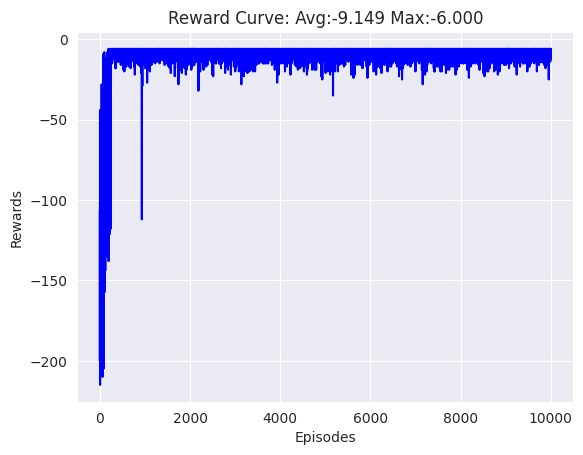

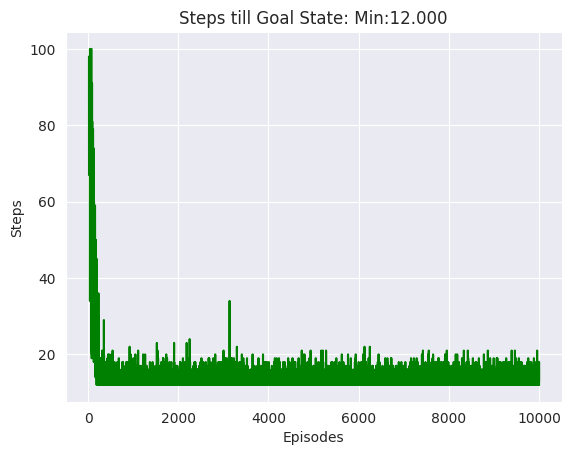

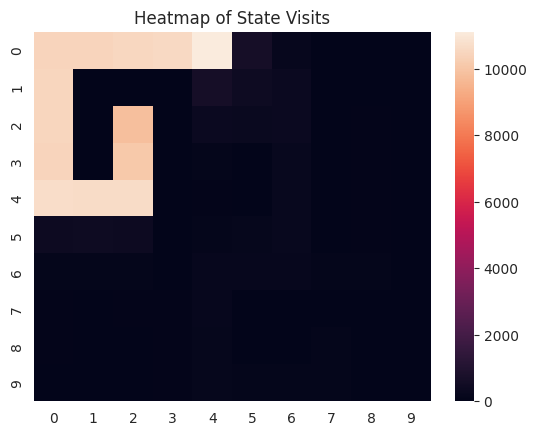

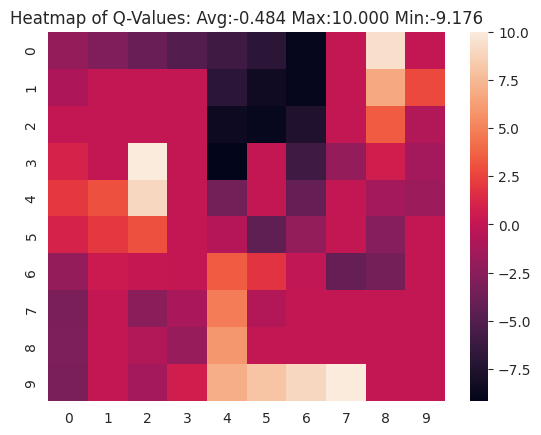

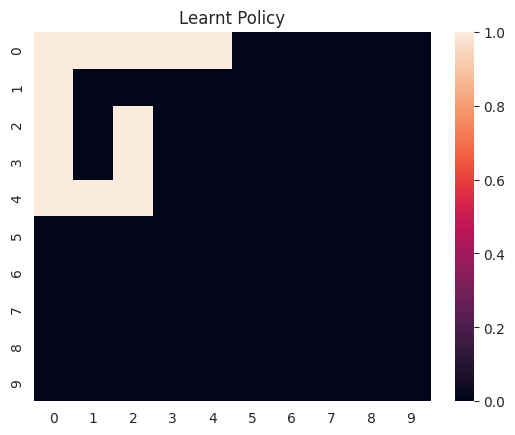

Training Episodes: 100%|████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1000.59it/s]


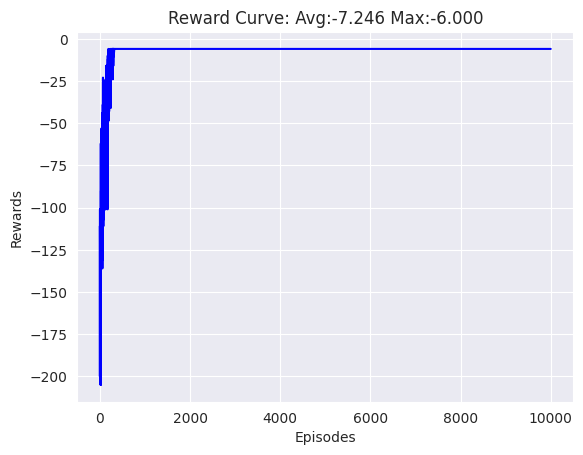

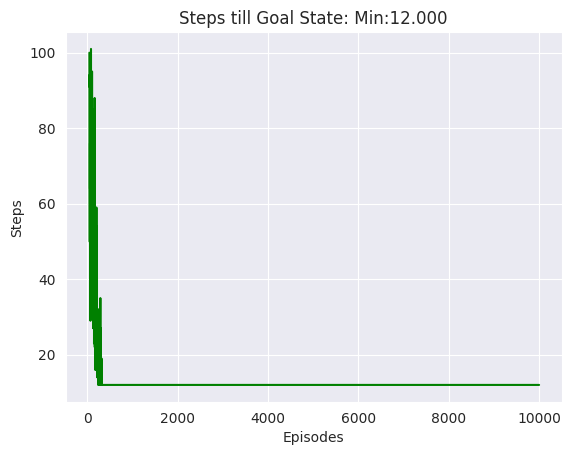

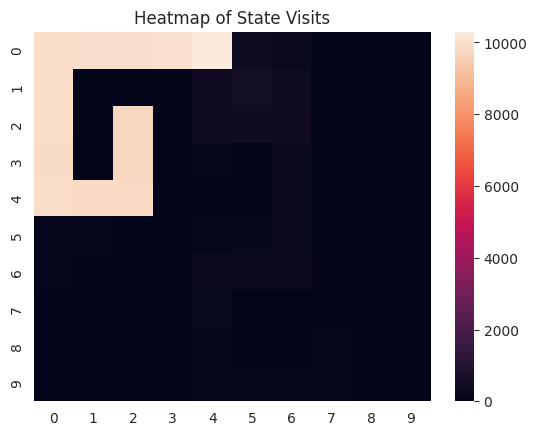

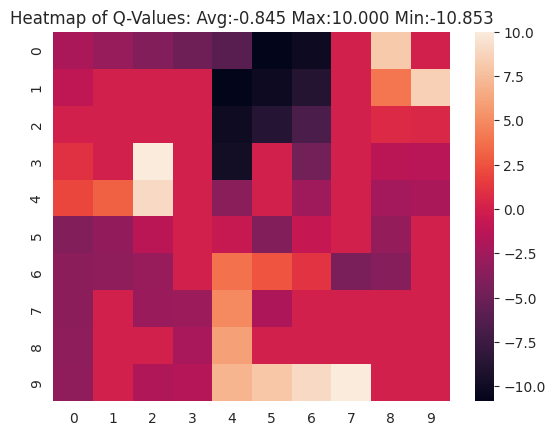

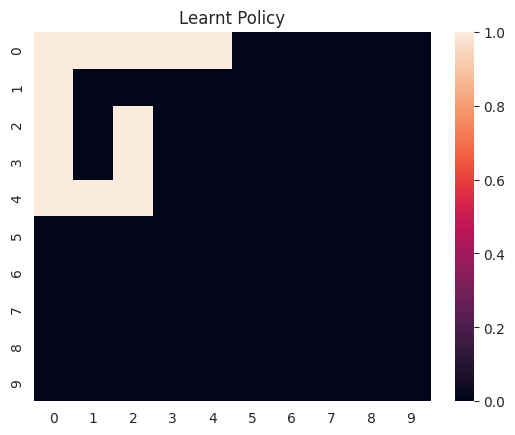

Training Episodes: 100%|████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1140.47it/s]


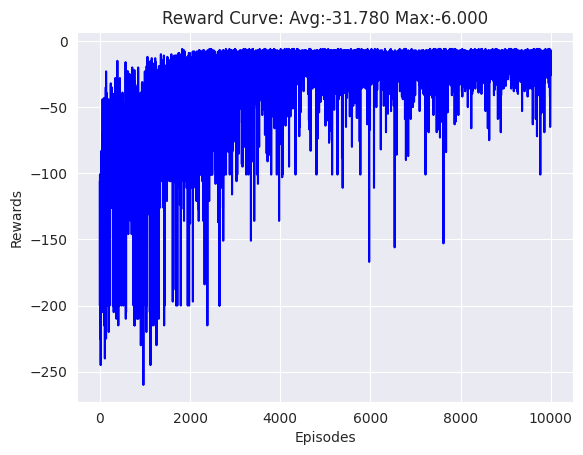

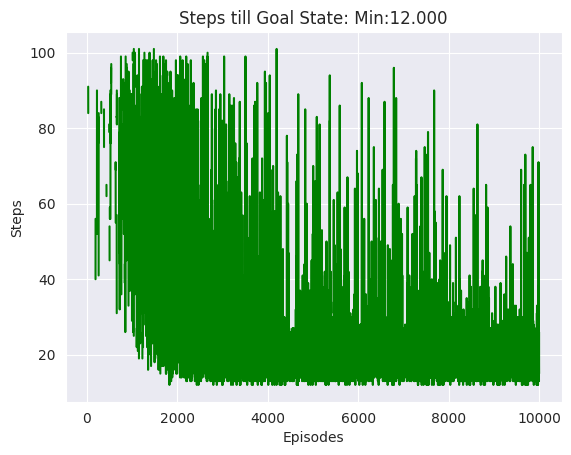

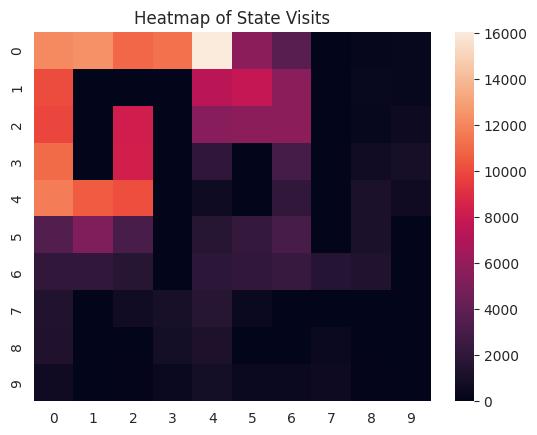

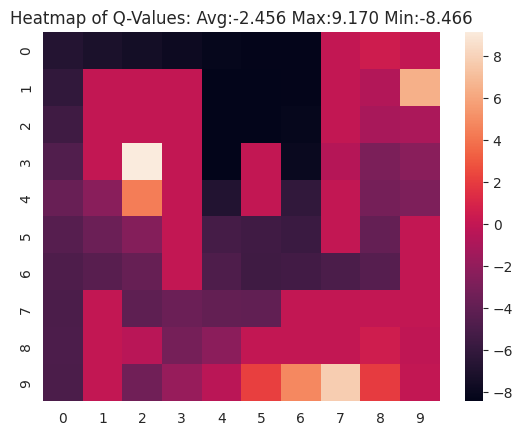

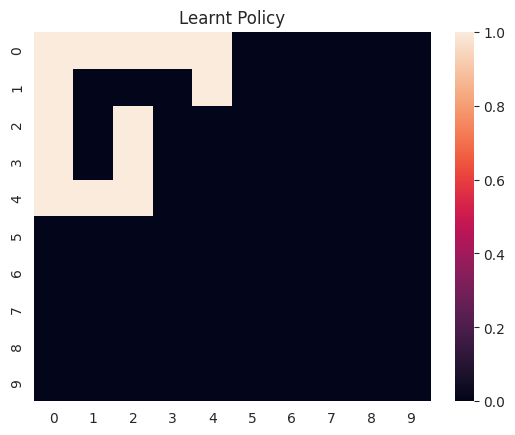

Training Episodes:  23%|█████████████▎                                            | 2286/10000 [00:17<00:52, 147.62it/s]

In [ ]:
with open('./logs/qlrng_log.txt', 'w') as f:

    sys.stdout = f 

    wind_states = [False, True]
    transition_prob = [1.0, 0.7]
    start_states = [[0, 4], [3, 6]]
    epsilon_soft = ['epsilon','softmax']

    

    for start in start_states:
        for wind_state in wind_states:
            for prob in transition_prob:
                for exp in epsilon_soft:

                    print("Running Experiment with parameters: Start State: {}, Wind: {}, Transition Probability: {}, Exploration Policy: {}".format(start, wind_state, prob, exp))
                    print()
                    print()
                    num_cols = 10
                    num_rows = 10
                    obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                                            [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                                            [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                                            [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

                    bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
                    restart_states = np.array([[3,7],[8,2]])
                    goal_states = np.array([[0,9],[2,2],[8,7]])

                    start_state = np.array([start])

                    # create model
                    gw = GridWorld(num_rows=num_rows,
                                    num_cols=num_cols,
                                    start_state=start_state,
                                    goal_states=goal_states, wind = wind_state)

                    gw.add_obstructions(obstructed_states=obstructions,
                                        bad_states=bad_states,
                                        restart_states=restart_states)

                    gw.add_rewards(step_reward=-1,
                                    goal_reward=10,
                                    bad_state_reward=-6,
                                    restart_state_reward=-100)

                    gw.add_transition_probability(p_good_transition=prob, bias=0.5)

                    env = gw.create_gridworld()

                    alphas = [0.001, 0.01, 0.1]
                    gammas = [0.8, 0.9, 1.0]

                    if exp == 'epsilon':
                        epsilons = [0.001, 0.01, 0.1]
                        print("Starting Asymptotic Grid Search:")
                        print()
                        best_reward, best_hyper_list = asymptotic_grid_search(env, alphas = alphas, gammas = gammas, epsilons = epsilons, update_rule = 'qlrng')
                        print("Starting Regret Grid Search:")
                        print()
                        best_regret, best_hyper_params = regret_grid_search(env, best_reward, best_hyper_list,  update_rule = 'qlrng', exploration_rule = 'epsilon' )

                        print("Creating Required Plots...")
                        print()
                        print()
                        trainer = TrainingIterator(env, QLearning(alpha = best_hyper_params['alpha'], gamma = best_hyper_params['gamma']), EpsilonGreedy(epsilon = best_hyper_params['alpha']), 10000)
                        trainer.train()
                        trainer.plot_reward_curve()
                        trainer.plot_steps()
                        trainer.plot_hmap_visits()
                        trainer.plot_hmap_qvals()
                        trainer.plot_learnt_policy(verbose = True )


                    else:
                        betas = [0.3, 1.0, 3.0]
                        print("Starting Asymptotic Grid Search:")
                        print()
                        best_reward, best_hyper_list = asymptotic_grid_search(env, alphas = alphas, gammas = gammas, betas = betas, update_rule = 'qlrng')
                        print("Starting Regret Grid Search:")
                        print()
                        best_regret, best_hyper_params = regret_grid_search(env, best_reward, best_hyper_list, update_rule = 'qlrng', exploration_rule = 'softmax')

                        print("Creating Required Plots...")
                        print()
                        print()
                        trainer = TrainingIterator(env, QLearning(alpha = best_hyper_params['alpha'], gamma = best_hyper_params['gamma']), SoftMax(beta = best_hyper_params['beta']), 10000)
                        trainer.train()
                        trainer.plot_reward_curve()
                        trainer.plot_steps()
                        trainer.plot_hmap_visits()
                        trainer.plot_hmap_qvals()
                        trainer.plot_learnt_policy(verbose = True )

### Running Expt 2

In [ ]:
# Fine tuning for noisy case
with open('./logs/qlrng_log1.txt', 'w') as f:

    sys.stdout = f 

    wind_states = [False, True]
    transition_prob = [0.7]
    start_states = [[0, 4], [3, 6]]
    epsilon_soft = ['epsilon']

    

    for start in start_states:
        for wind_state in wind_states:
            for prob in transition_prob:
                for exp in epsilon_soft:

                    print("Running Experiment with parameters: Start State: {}, Wind: {}, Transition Probability: {}, Exploration Policy: {}".format(start, wind_state, prob, exp))
                    print()
                    print()
                    num_cols = 10
                    num_rows = 10
                    obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                                            [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                                            [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                                            [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

                    bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
                    restart_states = np.array([[3,7],[8,2]])
                    goal_states = np.array([[0,9],[2,2],[8,7]])

                    start_state = np.array([start])

                    # create model
                    gw = GridWorld(num_rows=num_rows,
                                    num_cols=num_cols,
                                    start_state=start_state,
                                    goal_states=goal_states, wind = wind_state)

                    gw.add_obstructions(obstructed_states=obstructions,
                                        bad_states=bad_states,
                                        restart_states=restart_states)

                    gw.add_rewards(step_reward=-1,
                                    goal_reward=10,
                                    bad_state_reward=-6,
                                    restart_state_reward=-100)

                    gw.add_transition_probability(p_good_transition=prob, bias=0.5)

                    env = gw.create_gridworld()

                    alphas = [0.001, 0.005, 0.01, 0.05, 0.1]
                    gammas = [0.8, 0.9, 1.0]

                    if exp == 'epsilon':
                        epsilons = [0.001, 0.01, 0.1]
                        print("Starting Asymptotic Grid Search:")
                        print()
                        best_reward, best_hyper_list = asymptotic_grid_search(env, alphas = alphas, gammas = gammas, epsilons = epsilons, update_rule = 'qlrng')
                        print("Starting Regret Grid Search:")
                        print()
                        best_regret, best_hyper_params = regret_grid_search(env, best_reward, best_hyper_list,  update_rule = 'qlrng', exploration_rule = 'epsilon' )

                        print("Creating Required Plots...")
                        print()
                        print()
                        trainer = TrainingIterator(env, QLearning(alpha = best_hyper_params['alpha'], gamma = best_hyper_params['gamma']), EpsilonGreedy(epsilon = best_hyper_params['alpha']), 10000)
                        trainer.train()
                        trainer.plot_reward_curve()
                        trainer.plot_steps()
                        trainer.plot_hmap_visits()
                        trainer.plot_hmap_qvals()
                        trainer.plot_learnt_policy(verbose = True )


                    else:
                        betas = [0.3, 1.0, 3.0]
                        print("Starting Asymptotic Grid Search:")
                        print()
                        best_reward, best_hyper_list = asymptotic_grid_search(env, alphas = alphas, gammas = gammas, betas = betas, update_rule = 'qlrng')
                        print("Starting Regret Grid Search:")
                        print()
                        best_regret, best_hyper_params = regret_grid_search(env, best_reward, best_hyper_list, update_rule = 'qlrng', exploration_rule = 'softmax')

                        print("Creating Required Plots...")
                        print()
                        print()
                        trainer = TrainingIterator(env, QLearning(alpha = best_hyper_params['alpha'], gamma = best_hyper_params['gamma']), SoftMax(beta = best_hyper_params['beta']), 10000)
                        trainer.train()
                        trainer.plot_reward_curve()
                        trainer.plot_steps()
                        trainer.plot_hmap_visits()
                        trainer.plot_hmap_qvals()
                        trainer.plot_learnt_policy(verbose = True )

# SARSA - Grid Search 

We carry out the Grid Search first with very rough granularity to observe the behaviour of the different configurations of the environment for the various combinations of hyperparameters. The initial search is conducted on the following grid of values:

- $\alpha$ : 0.001 , 0.01 ,  0.1
- $\gamma$ : 0.50  , 0.75 ,  1.0
- $\beta$ : 1.0   , 5.0  , 10.0     (for softmax action selection cases)
- $\epsilon$ : 0.001 , 0.01 ,  0.1  (for $\epsilon$-greedy action selection cases)

There are a total of 27 hyperparameter configurations that are being tested here

In [ ]:
with open('./logs/sarsa_log.txt', 'w') as f:

    sys.stdout = f 

    wind_states = [False, True]
    transition_prob = [1.0, 0.7]
    start_states = [[0, 4], [3, 6]]
    epsilon_soft = ['epsilon','softmax']

    

    for start in start_states:
        for wind_state in wind_states:
            for prob in transition_prob:
                for exp in epsilon_soft:

                    print("Running Experiment with parameters: Start State: {}, Wind: {}, Transition Probability: {}, Exploration Policy: {}".format(start, wind_state, prob, exp))
                    print('-------------------------------------------------------------------------------------------------------')
                    print()
                    num_cols = 10
                    num_rows = 10
                    obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                                            [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                                            [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                                            [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

                    bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
                    restart_states = np.array([[3,7],[8,2]])
                    goal_states = np.array([[0,9],[2,2],[8,7]])

                    start_state = np.array([start])

                    # create model
                    gw = GridWorld(num_rows=num_rows,
                                    num_cols=num_cols,
                                    start_state=start_state,
                                    goal_states=goal_states, wind = wind_state)

                    gw.add_obstructions(obstructed_states=obstructions,
                                        bad_states=bad_states,
                                        restart_states=restart_states)

                    gw.add_rewards(step_reward=-1,
                                    goal_reward=10,
                                    bad_state_reward=-6,
                                    restart_state_reward=-100)

                    gw.add_transition_probability(p_good_transition=prob, bias=0.5)

                    env = gw.create_gridworld()

                    alphas = [0.001, 0.01, 0.1]
                    gammas = [0.8, 0.9, 1.0]

                    if exp == 'epsilon':
                        epsilons = [0.001, 0.01, 0.1]
                        print("Starting Asymptotic Grid Search:")
                        print()
                        best_reward, best_hyper_list = asymptotic_grid_search(env, alphas = alphas, gammas = gammas, epsilons = epsilons, update_rule = 'sarsa')
                        print("Starting Regret Grid Search:")
                        print()
                        best_regret, best_hyper_params = regret_grid_search(env, best_reward, best_hyper_list,  update_rule = 'sarsa', exploration_rule = 'epsilon' )

                        print("Creating Required Plots...")
                        print()
                        print()
                        trainer = TrainingIterator(env, SARSA(alpha = best_hyper_params['alpha'], gamma = best_hyper_params['gamma']), EpsilonGreedy(epsilon = best_hyper_params['alpha']), 10000)
                        trainer.train()
                        trainer.plot_reward_curve()
                        trainer.plot_steps()
                        trainer.plot_hmap_visits()
                        trainer.plot_hmap_qvals()
                        trainer.plot_learnt_policy(verbose = True )


                    else:
                        betas = [0.5, 1.0, 5.0]
                        print("Starting Asymptotic Grid Search:")
                        print()
                        best_reward, best_hyper_list = asymptotic_grid_search(env, alphas = alphas, gammas = gammas, betas = betas, update_rule = 'sarsa')
                        print("Starting Regret Grid Search:")
                        print()
                        best_regret, best_hyper_params = regret_grid_search(env, best_reward, best_hyper_list, update_rule = 'sarsa', exploration_rule = 'softmax')

                        print("Creating Required Plots...")
                        print()
                        print()
                        trainer = TrainingIterator(env, SARSA(alpha = best_hyper_params['alpha'], gamma = best_hyper_params['gamma']), SoftMax(beta = best_hyper_params['beta']), 10000)
                        trainer.train()
                        trainer.plot_reward_curve()
                        trainer.plot_steps()
                        trainer.plot_hmap_visits()
                        trainer.plot_hmap_qvals()
                        trainer.plot_learnt_policy(verbose = True )